## Classifying Bad Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [1]:
from __future__ import division, print_function, absolute_import
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2

### Set network parameters

In [2]:
# Dataset/Featurization Config
path = 'data/bad_fullcols.csv'
label = 'bad'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisbad_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [3]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [4]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False)

### Configure dataset

In [5]:
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/supermin_bad_20k_fullcols.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
Tuning tf-idf classifier.
Featurizing training set.
Featurizing test set.
Finished configuring dataset.


### Prepare model configurations

In [6]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [7]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [8]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [9]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/Users/jwei/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
# Initializing the variables
init = tf.initialize_all_variables()

### Train model

In [11]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.693570, Training Accuracy= 0.40000
Iter 300, Minibatch Loss= 0.666570, Training Accuracy= 0.46667
Iter 450, Minibatch Loss= 0.654025, Training Accuracy= 0.46667
Iter 600, Minibatch Loss= 0.594712, Training Accuracy= 0.53333
Iter 750, Minibatch Loss= 0.524026, Training Accuracy= 0.80000
Validation Accuracy: 0.6482
Validation Loss: 0.645801


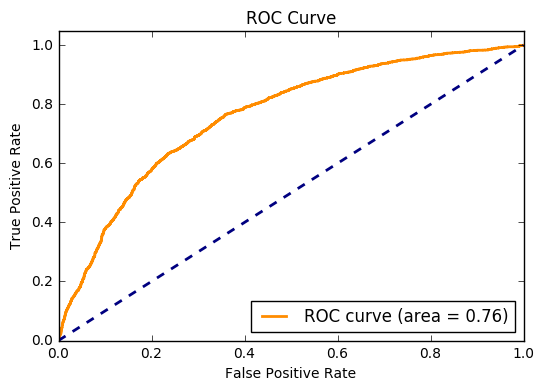

Iter 900, Minibatch Loss= 0.532422, Training Accuracy= 0.86667
Iter 1050, Minibatch Loss= 0.593433, Training Accuracy= 0.80000
Iter 1200, Minibatch Loss= 0.885441, Training Accuracy= 0.60000
Iter 1350, Minibatch Loss= 0.509086, Training Accuracy= 0.80000
Iter 1500, Minibatch Loss= 0.449101, Training Accuracy= 0.86667
Validation Accuracy: 0.6204
Validation Loss: 0.633515
Iter 1650, Minibatch Loss= 0.478250, Training Accuracy= 0.86667
Iter 1800, Minibatch Loss= 0.533936, Training Accuracy= 0.80000
Iter 1950, Minibatch Loss= 0.604424, Training Accuracy= 0.66667
Iter 2100, Minibatch Loss= 0.571910, Training Accuracy= 0.66667
Iter 2250, Minibatch Loss= 0.523011, Training Accuracy= 0.73333
Validation Accuracy: 0.6844
Validation Loss: 0.601835


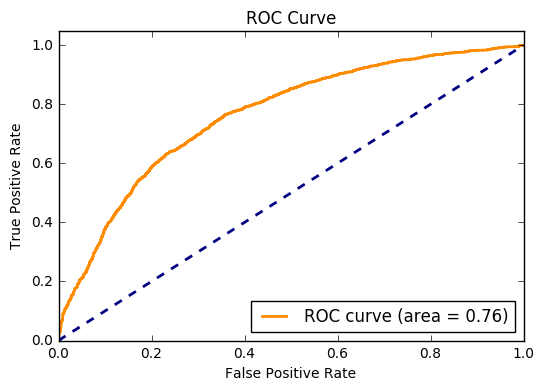

Iter 2400, Minibatch Loss= 0.550610, Training Accuracy= 0.66667
Iter 2550, Minibatch Loss= 0.666041, Training Accuracy= 0.53333
Iter 2700, Minibatch Loss= 0.488973, Training Accuracy= 0.93333
Iter 2850, Minibatch Loss= 0.543091, Training Accuracy= 0.60000
Iter 3000, Minibatch Loss= 0.605328, Training Accuracy= 0.60000
Validation Accuracy: 0.6996
Validation Loss: 0.600149


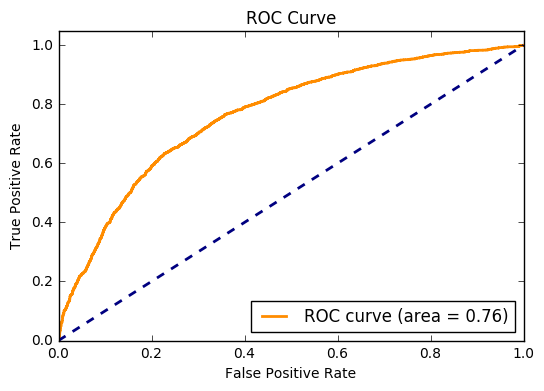

Iter 3150, Minibatch Loss= 0.668320, Training Accuracy= 0.60000
Iter 3300, Minibatch Loss= 0.692143, Training Accuracy= 0.53333
Iter 3450, Minibatch Loss= 0.783104, Training Accuracy= 0.66667
Iter 3600, Minibatch Loss= 0.500903, Training Accuracy= 0.86667
Iter 3750, Minibatch Loss= 0.425600, Training Accuracy= 1.00000
Validation Accuracy: 0.7014
Validation Loss: 0.590461


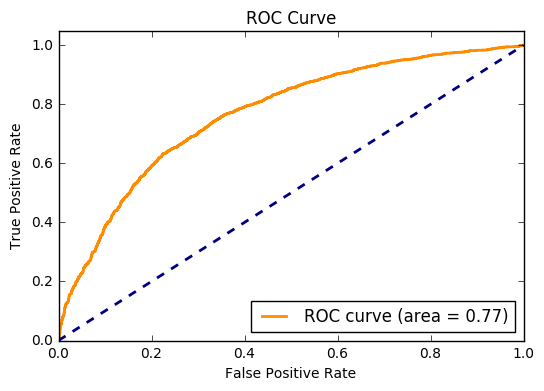

Iter 3900, Minibatch Loss= 0.572689, Training Accuracy= 0.73333
Iter 4050, Minibatch Loss= 0.779550, Training Accuracy= 0.53333
Iter 4200, Minibatch Loss= 0.494079, Training Accuracy= 0.73333
Iter 4350, Minibatch Loss= 0.567915, Training Accuracy= 0.66667
Iter 4500, Minibatch Loss= 0.569936, Training Accuracy= 0.80000
Validation Accuracy: 0.7038
Validation Loss: 0.589846


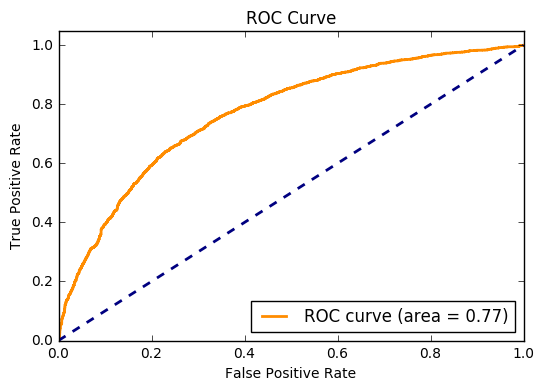

Iter 4650, Minibatch Loss= 0.537032, Training Accuracy= 0.86667
Iter 4800, Minibatch Loss= 0.483639, Training Accuracy= 0.80000
Iter 4950, Minibatch Loss= 0.441578, Training Accuracy= 0.80000
Iter 5100, Minibatch Loss= 0.732876, Training Accuracy= 0.60000
Iter 5250, Minibatch Loss= 1.276521, Training Accuracy= 0.66667
Validation Accuracy: 0.6816
Validation Loss: 0.602238
Iter 5400, Minibatch Loss= 0.594687, Training Accuracy= 0.60000
Iter 5550, Minibatch Loss= 0.512559, Training Accuracy= 0.86667
Iter 5700, Minibatch Loss= 0.662734, Training Accuracy= 0.53333
Iter 5850, Minibatch Loss= 0.631337, Training Accuracy= 0.60000
Iter 6000, Minibatch Loss= 0.608633, Training Accuracy= 0.73333
Validation Accuracy: 0.682
Validation Loss: 0.595483
Iter 6150, Minibatch Loss= 0.540730, Training Accuracy= 0.86667
Iter 6300, Minibatch Loss= 0.571933, Training Accuracy= 0.60000
Iter 6450, Minibatch Loss= 0.489609, Training Accuracy= 0.86667
Iter 6600, Minibatch Loss= 0.777338, Training Accuracy= 0.666

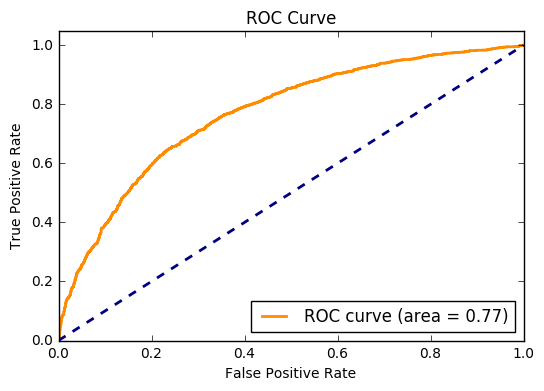

Iter 6900, Minibatch Loss= 0.694451, Training Accuracy= 0.66667
Iter 7050, Minibatch Loss= 0.352821, Training Accuracy= 0.86667
Iter 7200, Minibatch Loss= 0.597655, Training Accuracy= 0.80000
Iter 7350, Minibatch Loss= 0.675224, Training Accuracy= 0.53333
Iter 7500, Minibatch Loss= 0.668101, Training Accuracy= 0.66667
Validation Accuracy: 0.6946
Validation Loss: 0.593279
Iter 7650, Minibatch Loss= 0.522136, Training Accuracy= 0.73333
Iter 7800, Minibatch Loss= 0.435749, Training Accuracy= 0.86667
Iter 7950, Minibatch Loss= 0.515174, Training Accuracy= 0.73333
Iter 8100, Minibatch Loss= 0.683586, Training Accuracy= 0.46667
Iter 8250, Minibatch Loss= 0.733509, Training Accuracy= 0.53333
Validation Accuracy: 0.695
Validation Loss: 0.590978
Iter 8400, Minibatch Loss= 0.521459, Training Accuracy= 0.80000
Iter 8550, Minibatch Loss= 0.617915, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.620994, Training Accuracy= 0.66667
Iter 8850, Minibatch Loss= 0.893675, Training Accuracy= 0.466

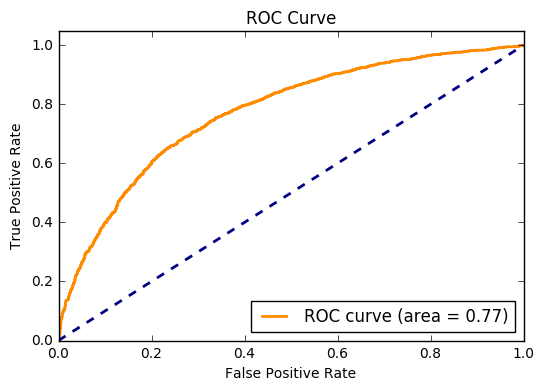

Iter 9900, Minibatch Loss= 0.519918, Training Accuracy= 0.80000
Iter 10050, Minibatch Loss= 0.359297, Training Accuracy= 0.86667
Iter 10200, Minibatch Loss= 0.536219, Training Accuracy= 0.66667
Iter 10350, Minibatch Loss= 0.578534, Training Accuracy= 0.66667
Iter 10500, Minibatch Loss= 0.502199, Training Accuracy= 0.80000
Validation Accuracy: 0.6864
Validation Loss: 0.590615
Iter 10650, Minibatch Loss= 0.533802, Training Accuracy= 0.73333
Iter 10800, Minibatch Loss= 0.598860, Training Accuracy= 0.60000
Iter 10950, Minibatch Loss= 0.569429, Training Accuracy= 0.73333
Iter 11100, Minibatch Loss= 0.608059, Training Accuracy= 0.73333
Iter 11250, Minibatch Loss= 0.572151, Training Accuracy= 0.73333
Validation Accuracy: 0.707
Validation Loss: 0.581808


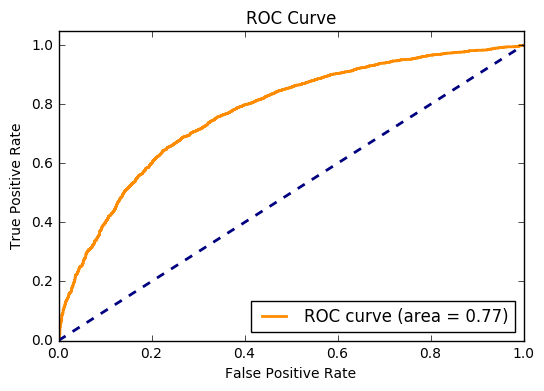

Iter 11400, Minibatch Loss= 0.489165, Training Accuracy= 0.66667
Iter 11550, Minibatch Loss= 0.508673, Training Accuracy= 0.80000
Iter 11700, Minibatch Loss= 0.456434, Training Accuracy= 0.66667
Iter 11850, Minibatch Loss= 0.484010, Training Accuracy= 0.73333
Iter 12000, Minibatch Loss= 0.522729, Training Accuracy= 0.73333
Validation Accuracy: 0.7062
Validation Loss: 0.595903
Iter 12150, Minibatch Loss= 0.552022, Training Accuracy= 0.66667
Iter 12300, Minibatch Loss= 0.612912, Training Accuracy= 0.66667
Iter 12450, Minibatch Loss= 0.550395, Training Accuracy= 0.66667
Iter 12600, Minibatch Loss= 0.411510, Training Accuracy= 0.80000
Iter 12750, Minibatch Loss= 0.504094, Training Accuracy= 0.80000
Validation Accuracy: 0.7066
Validation Loss: 0.59825
Iter 12900, Minibatch Loss= 1.487597, Training Accuracy= 0.53333
Iter 13050, Minibatch Loss= 0.561736, Training Accuracy= 0.53333
Iter 13200, Minibatch Loss= 0.630231, Training Accuracy= 0.60000
Iter 13350, Minibatch Loss= 0.526827, Training A

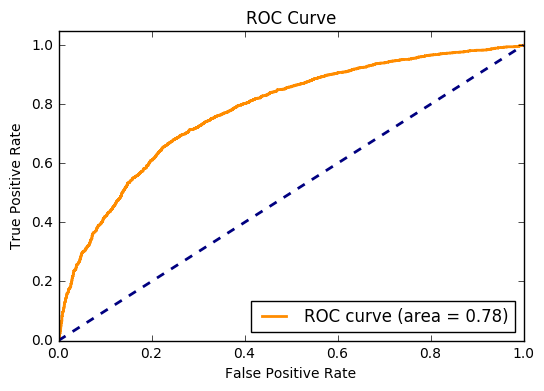

Iter 14400, Minibatch Loss= 0.479720, Training Accuracy= 0.80000
Iter 14550, Minibatch Loss= 0.458861, Training Accuracy= 0.73333
Iter 14700, Minibatch Loss= 0.436384, Training Accuracy= 0.93333
Iter 14850, Minibatch Loss= 0.447355, Training Accuracy= 0.80000
Iter 15000, Minibatch Loss= 0.335818, Training Accuracy= 0.93333
Validation Accuracy: 0.7118
Validation Loss: 0.57818
Iter 15150, Minibatch Loss= 0.513918, Training Accuracy= 0.73333
Iter 15300, Minibatch Loss= 0.545655, Training Accuracy= 0.73333
Iter 15450, Minibatch Loss= 0.566483, Training Accuracy= 0.66667
Iter 15600, Minibatch Loss= 0.572383, Training Accuracy= 0.73333
Iter 15750, Minibatch Loss= 0.497774, Training Accuracy= 0.73333
Validation Accuracy: 0.6912
Validation Loss: 0.586441
Iter 15900, Minibatch Loss= 0.351668, Training Accuracy= 0.86667
Iter 16050, Minibatch Loss= 0.471445, Training Accuracy= 0.80000
Iter 16200, Minibatch Loss= 0.786286, Training Accuracy= 0.66667
Iter 16350, Minibatch Loss= 0.506480, Training A

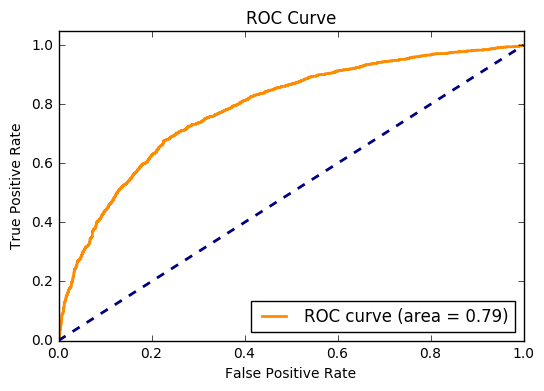

Iter 18900, Minibatch Loss= 0.555081, Training Accuracy= 0.73333
Iter 19050, Minibatch Loss= 0.733317, Training Accuracy= 0.60000
Iter 19200, Minibatch Loss= 0.485213, Training Accuracy= 0.73333
Iter 19350, Minibatch Loss= 0.552390, Training Accuracy= 0.66667
Iter 19500, Minibatch Loss= 0.571743, Training Accuracy= 0.80000
Validation Accuracy: 0.724
Validation Loss: 0.56938


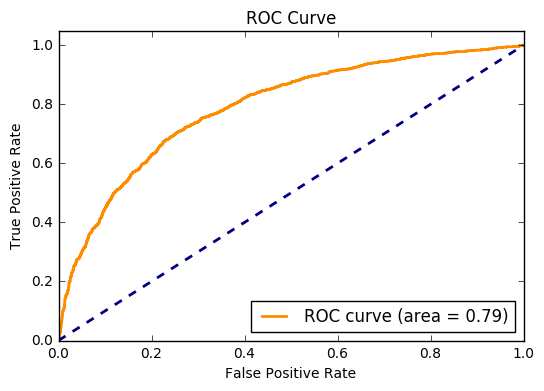

Iter 19650, Minibatch Loss= 0.500679, Training Accuracy= 0.66667
Iter 19800, Minibatch Loss= 0.441285, Training Accuracy= 0.80000
Iter 19950, Minibatch Loss= 0.438175, Training Accuracy= 0.80000
Iter 20100, Minibatch Loss= 0.683574, Training Accuracy= 0.60000
Iter 20250, Minibatch Loss= 1.202222, Training Accuracy= 0.66667
Validation Accuracy: 0.691
Validation Loss: 0.586453
Iter 20400, Minibatch Loss= 0.579285, Training Accuracy= 0.66667
Iter 20550, Minibatch Loss= 0.499184, Training Accuracy= 0.80000
Iter 20700, Minibatch Loss= 0.601841, Training Accuracy= 0.60000
Iter 20850, Minibatch Loss= 0.692809, Training Accuracy= 0.53333
Iter 21000, Minibatch Loss= 0.594316, Training Accuracy= 0.73333
Validation Accuracy: 0.6944
Validation Loss: 0.578553
Iter 21150, Minibatch Loss= 0.463523, Training Accuracy= 0.86667
Iter 21300, Minibatch Loss= 0.583029, Training Accuracy= 0.66667
Iter 21450, Minibatch Loss= 0.499936, Training Accuracy= 0.80000
Iter 21600, Minibatch Loss= 0.741420, Training A

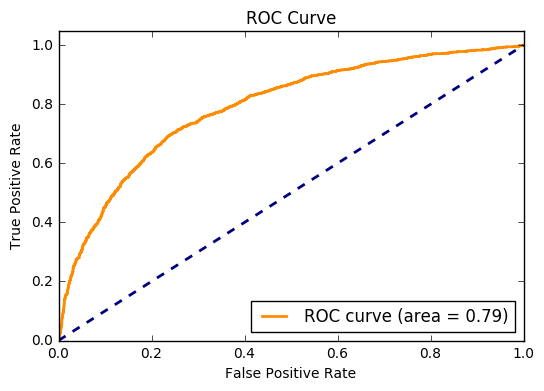

Iter 21900, Minibatch Loss= 0.676247, Training Accuracy= 0.66667
Iter 22050, Minibatch Loss= 0.326111, Training Accuracy= 0.86667
Iter 22200, Minibatch Loss= 0.607147, Training Accuracy= 0.60000
Iter 22350, Minibatch Loss= 0.662041, Training Accuracy= 0.53333
Iter 22500, Minibatch Loss= 0.648009, Training Accuracy= 0.66667
Validation Accuracy: 0.7196
Validation Loss: 0.576465
Iter 22650, Minibatch Loss= 0.476828, Training Accuracy= 0.73333
Iter 22800, Minibatch Loss= 0.383679, Training Accuracy= 0.86667
Iter 22950, Minibatch Loss= 0.521673, Training Accuracy= 0.73333
Iter 23100, Minibatch Loss= 0.650864, Training Accuracy= 0.60000
Iter 23250, Minibatch Loss= 0.700646, Training Accuracy= 0.66667
Validation Accuracy: 0.7296
Validation Loss: 0.565023


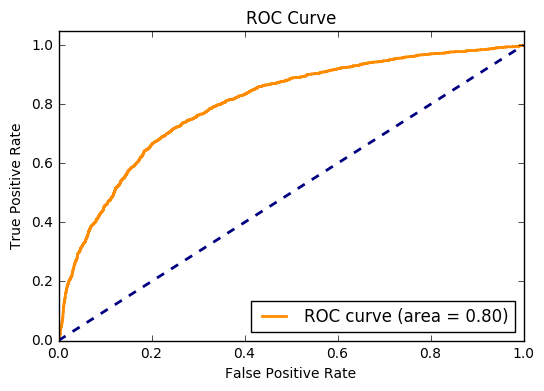

Iter 23400, Minibatch Loss= 0.508685, Training Accuracy= 0.80000
Iter 23550, Minibatch Loss= 0.598492, Training Accuracy= 0.73333
Iter 23700, Minibatch Loss= 0.467219, Training Accuracy= 0.80000
Iter 23850, Minibatch Loss= 0.823211, Training Accuracy= 0.46667
Iter 24000, Minibatch Loss= 0.577316, Training Accuracy= 0.73333
Validation Accuracy: 0.7286
Validation Loss: 0.564342
Iter 24150, Minibatch Loss= 0.533547, Training Accuracy= 0.80000
Iter 24300, Minibatch Loss= 0.887693, Training Accuracy= 0.73333
Iter 24450, Minibatch Loss= 0.517793, Training Accuracy= 0.73333
Iter 24600, Minibatch Loss= 0.743591, Training Accuracy= 0.53333
Iter 24750, Minibatch Loss= 0.499300, Training Accuracy= 0.80000
Validation Accuracy: 0.7348
Validation Loss: 0.558166


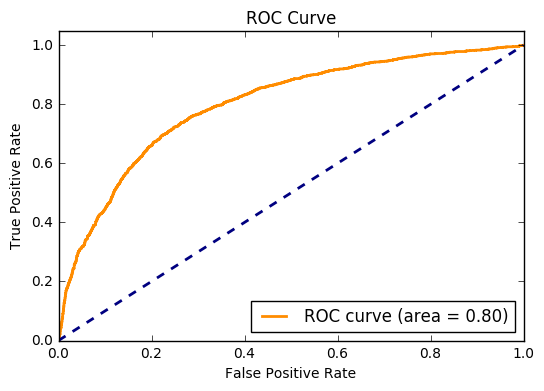

Iter 24900, Minibatch Loss= 0.525604, Training Accuracy= 0.66667
Iter 25050, Minibatch Loss= 0.206269, Training Accuracy= 1.00000
Iter 25200, Minibatch Loss= 0.541890, Training Accuracy= 0.60000
Iter 25350, Minibatch Loss= 0.527741, Training Accuracy= 0.73333
Iter 25500, Minibatch Loss= 0.381547, Training Accuracy= 0.86667
Validation Accuracy: 0.7158
Validation Loss: 0.564038
Iter 25650, Minibatch Loss= 0.548198, Training Accuracy= 0.73333
Iter 25800, Minibatch Loss= 0.613478, Training Accuracy= 0.66667
Iter 25950, Minibatch Loss= 0.510891, Training Accuracy= 0.80000
Iter 26100, Minibatch Loss= 0.578093, Training Accuracy= 0.73333
Iter 26250, Minibatch Loss= 0.521329, Training Accuracy= 0.66667
Validation Accuracy: 0.6904
Validation Loss: 0.584657
Iter 26400, Minibatch Loss= 0.476403, Training Accuracy= 0.80000
Iter 26550, Minibatch Loss= 0.488194, Training Accuracy= 0.73333
Iter 26700, Minibatch Loss= 0.533150, Training Accuracy= 0.60000
Iter 26850, Minibatch Loss= 0.390340, Training 

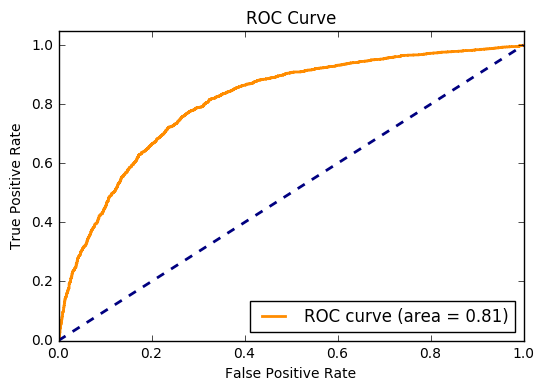

Iter 28650, Minibatch Loss= 0.292980, Training Accuracy= 0.93333
Iter 28800, Minibatch Loss= 0.382609, Training Accuracy= 0.80000
Iter 28950, Minibatch Loss= 0.515690, Training Accuracy= 0.73333
Iter 29100, Minibatch Loss= 0.495899, Training Accuracy= 0.93333
Iter 29250, Minibatch Loss= 0.472497, Training Accuracy= 0.66667
Validation Accuracy: 0.731
Validation Loss: 0.552397
Iter 29400, Minibatch Loss= 0.439007, Training Accuracy= 0.86667
Iter 29550, Minibatch Loss= 0.537236, Training Accuracy= 0.66667
Iter 29700, Minibatch Loss= 0.415131, Training Accuracy= 0.86667
Iter 29850, Minibatch Loss= 0.441972, Training Accuracy= 0.80000
Iter 30000, Minibatch Loss= 0.303970, Training Accuracy= 0.86667
Validation Accuracy: 0.7354
Validation Loss: 0.555983
Iter 30150, Minibatch Loss= 0.488948, Training Accuracy= 0.73333
Iter 30300, Minibatch Loss= 0.478215, Training Accuracy= 0.73333
Iter 30450, Minibatch Loss= 0.564631, Training Accuracy= 0.66667
Iter 30600, Minibatch Loss= 0.491597, Training A

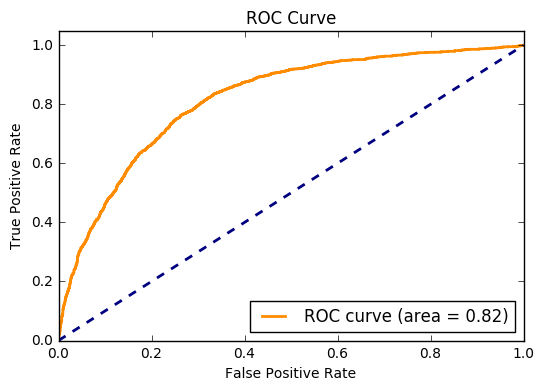

Iter 39900, Minibatch Loss= 0.520219, Training Accuracy= 0.73333
Iter 40050, Minibatch Loss= 0.238678, Training Accuracy= 1.00000
Iter 40200, Minibatch Loss= 0.539539, Training Accuracy= 0.60000
Iter 40350, Minibatch Loss= 0.510329, Training Accuracy= 0.73333
Iter 40500, Minibatch Loss= 0.331980, Training Accuracy= 0.93333
Validation Accuracy: 0.7054
Validation Loss: 0.569957
Iter 40650, Minibatch Loss= 0.516858, Training Accuracy= 0.73333
Iter 40800, Minibatch Loss= 0.648500, Training Accuracy= 0.66667
Iter 40950, Minibatch Loss= 0.493650, Training Accuracy= 0.80000
Iter 41100, Minibatch Loss= 0.555333, Training Accuracy= 0.73333
Iter 41250, Minibatch Loss= 0.502653, Training Accuracy= 0.73333
Validation Accuracy: 0.7386
Validation Loss: 0.554335
Iter 41400, Minibatch Loss= 0.458555, Training Accuracy= 0.80000
Iter 41550, Minibatch Loss= 0.482285, Training Accuracy= 0.73333
Iter 41700, Minibatch Loss= 0.462093, Training Accuracy= 0.80000
Iter 41850, Minibatch Loss= 0.369174, Training 

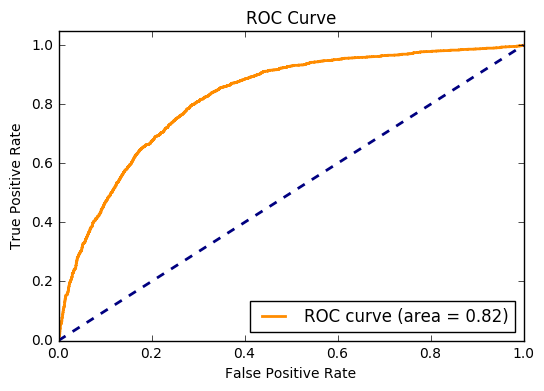

Iter 46650, Minibatch Loss= 0.262899, Training Accuracy= 0.93333
Iter 46800, Minibatch Loss= 0.401159, Training Accuracy= 0.86667
Iter 46950, Minibatch Loss= 0.657769, Training Accuracy= 0.73333
Iter 47100, Minibatch Loss= 0.540222, Training Accuracy= 0.80000
Iter 47250, Minibatch Loss= 0.520892, Training Accuracy= 0.66667
Validation Accuracy: 0.7192
Validation Loss: 0.565986
Iter 47400, Minibatch Loss= 0.595805, Training Accuracy= 0.73333
Iter 47550, Minibatch Loss= 0.633178, Training Accuracy= 0.60000
Iter 47700, Minibatch Loss= 0.406400, Training Accuracy= 0.86667
Iter 47850, Minibatch Loss= 0.546149, Training Accuracy= 0.66667
Iter 48000, Minibatch Loss= 0.517866, Training Accuracy= 0.66667
Validation Accuracy: 0.6916
Validation Loss: 0.59837
Iter 48150, Minibatch Loss= 0.675440, Training Accuracy= 0.53333
Iter 48300, Minibatch Loss= 0.557082, Training Accuracy= 0.73333
Iter 48450, Minibatch Loss= 0.740799, Training Accuracy= 0.60000
Iter 48600, Minibatch Loss= 0.414284, Training A

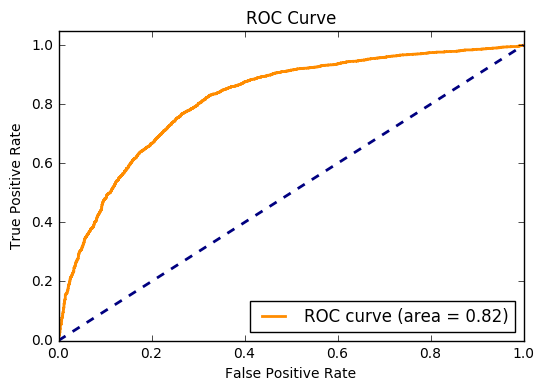

Iter 51900, Minibatch Loss= 0.594453, Training Accuracy= 0.60000
Iter 52050, Minibatch Loss= 0.310595, Training Accuracy= 0.86667
Iter 52200, Minibatch Loss= 0.602295, Training Accuracy= 0.66667
Iter 52350, Minibatch Loss= 0.638034, Training Accuracy= 0.60000
Iter 52500, Minibatch Loss= 0.594682, Training Accuracy= 0.80000
Validation Accuracy: 0.743
Validation Loss: 0.537369
Iter 52650, Minibatch Loss= 0.436313, Training Accuracy= 0.86667
Iter 52800, Minibatch Loss= 0.333999, Training Accuracy= 0.93333
Iter 52950, Minibatch Loss= 0.573496, Training Accuracy= 0.73333
Iter 53100, Minibatch Loss= 0.659180, Training Accuracy= 0.60000
Iter 53250, Minibatch Loss= 0.536951, Training Accuracy= 0.80000
Validation Accuracy: 0.7328
Validation Loss: 0.539489
Iter 53400, Minibatch Loss= 0.526517, Training Accuracy= 0.73333
Iter 53550, Minibatch Loss= 0.544804, Training Accuracy= 0.66667
Iter 53700, Minibatch Loss= 0.425952, Training Accuracy= 0.86667
Iter 53850, Minibatch Loss= 0.737017, Training A

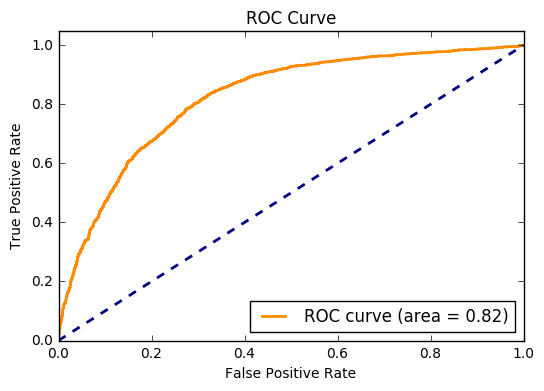

Iter 54900, Minibatch Loss= 0.508262, Training Accuracy= 0.73333
Iter 55050, Minibatch Loss= 0.262019, Training Accuracy= 1.00000
Iter 55200, Minibatch Loss= 0.541204, Training Accuracy= 0.60000
Iter 55350, Minibatch Loss= 0.506597, Training Accuracy= 0.73333
Iter 55500, Minibatch Loss= 0.324260, Training Accuracy= 0.93333
Validation Accuracy: 0.7046
Validation Loss: 0.564359
Iter 55650, Minibatch Loss= 0.549475, Training Accuracy= 0.73333
Iter 55800, Minibatch Loss= 0.651223, Training Accuracy= 0.66667
Iter 55950, Minibatch Loss= 0.472557, Training Accuracy= 0.80000
Iter 56100, Minibatch Loss= 0.561722, Training Accuracy= 0.73333
Iter 56250, Minibatch Loss= 0.463968, Training Accuracy= 0.73333
Validation Accuracy: 0.7418
Validation Loss: 0.540228
Iter 56400, Minibatch Loss= 0.437916, Training Accuracy= 0.86667
Iter 56550, Minibatch Loss= 0.506234, Training Accuracy= 0.73333
Iter 56700, Minibatch Loss= 0.455247, Training Accuracy= 0.73333
Iter 56850, Minibatch Loss= 0.331619, Training 

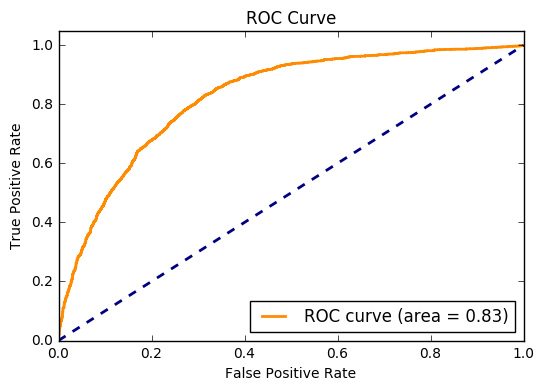

Iter 61650, Minibatch Loss= 0.206716, Training Accuracy= 0.93333
Iter 61800, Minibatch Loss= 0.361190, Training Accuracy= 0.86667
Iter 61950, Minibatch Loss= 0.671962, Training Accuracy= 0.66667
Iter 62100, Minibatch Loss= 0.564373, Training Accuracy= 0.80000
Iter 62250, Minibatch Loss= 0.514221, Training Accuracy= 0.66667
Validation Accuracy: 0.7374
Validation Loss: 0.538867
Iter 62400, Minibatch Loss= 0.571088, Training Accuracy= 0.73333
Iter 62550, Minibatch Loss= 0.589781, Training Accuracy= 0.66667
Iter 62700, Minibatch Loss= 0.380704, Training Accuracy= 0.86667
Iter 62850, Minibatch Loss= 0.506926, Training Accuracy= 0.73333
Iter 63000, Minibatch Loss= 0.537727, Training Accuracy= 0.66667
Validation Accuracy: 0.6818
Validation Loss: 0.629083
Iter 63150, Minibatch Loss= 0.681204, Training Accuracy= 0.60000
Iter 63300, Minibatch Loss= 0.567362, Training Accuracy= 0.73333
Iter 63450, Minibatch Loss= 0.715026, Training Accuracy= 0.60000
Iter 63600, Minibatch Loss= 0.404900, Training 

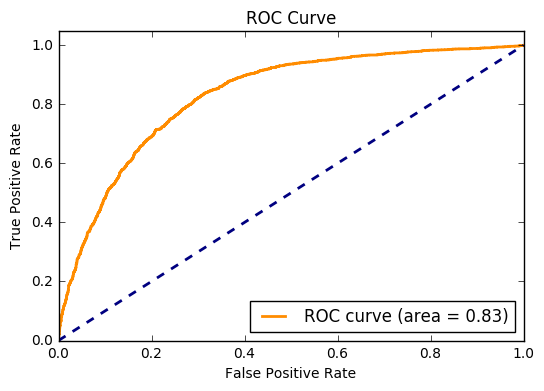

Iter 84150, Minibatch Loss= 0.391378, Training Accuracy= 0.93333
Iter 84300, Minibatch Loss= 0.708285, Training Accuracy= 0.66667
Iter 84450, Minibatch Loss= 0.419436, Training Accuracy= 0.73333
Iter 84600, Minibatch Loss= 0.800208, Training Accuracy= 0.40000
Iter 84750, Minibatch Loss= 0.432110, Training Accuracy= 0.80000
Validation Accuracy: 0.7598
Validation Loss: 0.521037
Iter 84900, Minibatch Loss= 0.507016, Training Accuracy= 0.73333
Iter 85050, Minibatch Loss= 0.249904, Training Accuracy= 1.00000
Iter 85200, Minibatch Loss= 0.490752, Training Accuracy= 0.73333
Iter 85350, Minibatch Loss= 0.506505, Training Accuracy= 0.73333
Iter 85500, Minibatch Loss= 0.310983, Training Accuracy= 0.93333
Validation Accuracy: 0.7232
Validation Loss: 0.55663
Iter 85650, Minibatch Loss= 0.520197, Training Accuracy= 0.73333
Iter 85800, Minibatch Loss= 0.614823, Training Accuracy= 0.66667
Iter 85950, Minibatch Loss= 0.478358, Training Accuracy= 0.80000
Iter 86100, Minibatch Loss= 0.558999, Training A

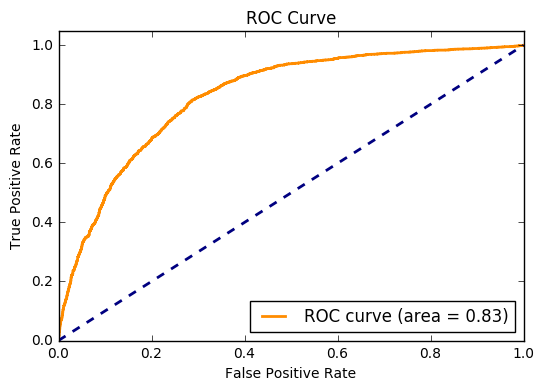

Iter 111150, Minibatch Loss= 0.419517, Training Accuracy= 0.80000
Iter 111300, Minibatch Loss= 0.547248, Training Accuracy= 0.73333
Iter 111450, Minibatch Loss= 0.442875, Training Accuracy= 0.93333
Iter 111600, Minibatch Loss= 0.712349, Training Accuracy= 0.66667
Iter 111750, Minibatch Loss= 0.305800, Training Accuracy= 0.86667
Validation Accuracy: 0.7586
Validation Loss: 0.512641
Iter 111900, Minibatch Loss= 0.593635, Training Accuracy= 0.60000
Iter 112050, Minibatch Loss= 0.336218, Training Accuracy= 0.86667
Iter 112200, Minibatch Loss= 0.566652, Training Accuracy= 0.66667
Iter 112350, Minibatch Loss= 0.590642, Training Accuracy= 0.73333
Iter 112500, Minibatch Loss= 0.568376, Training Accuracy= 0.66667
Validation Accuracy: 0.7488
Validation Loss: 0.521482
Iter 112650, Minibatch Loss= 0.395634, Training Accuracy= 0.86667
Iter 112800, Minibatch Loss= 0.310902, Training Accuracy= 0.93333
Iter 112950, Minibatch Loss= 0.566406, Training Accuracy= 0.66667
Iter 113100, Minibatch Loss= 0.552

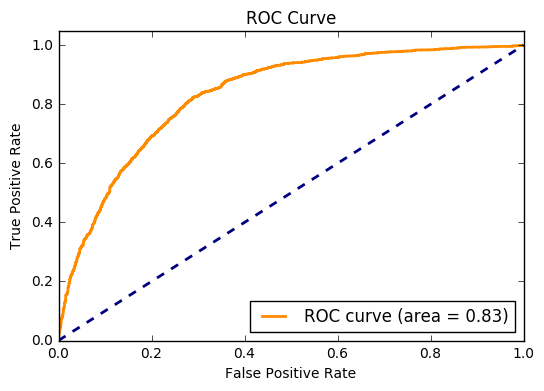

Iter 134400, Minibatch Loss= 0.403700, Training Accuracy= 0.86667
Iter 134550, Minibatch Loss= 0.373213, Training Accuracy= 0.93333
Iter 134700, Minibatch Loss= 0.417044, Training Accuracy= 0.86667
Iter 134850, Minibatch Loss= 0.381409, Training Accuracy= 0.86667
Iter 135000, Minibatch Loss= 0.350450, Training Accuracy= 0.93333
Validation Accuracy: 0.7576
Validation Loss: 0.537088
Iter 135150, Minibatch Loss= 0.393886, Training Accuracy= 0.73333
Iter 135300, Minibatch Loss= 0.412598, Training Accuracy= 0.80000
Iter 135450, Minibatch Loss= 0.518903, Training Accuracy= 0.66667
Iter 135600, Minibatch Loss= 0.429454, Training Accuracy= 0.86667
Iter 135750, Minibatch Loss= 0.489064, Training Accuracy= 0.73333
Validation Accuracy: 0.7612
Validation Loss: 0.50901
Iter 135900, Minibatch Loss= 0.315544, Training Accuracy= 0.86667
Iter 136050, Minibatch Loss= 0.430914, Training Accuracy= 0.86667
Iter 136200, Minibatch Loss= 0.744316, Training Accuracy= 0.66667
Iter 136350, Minibatch Loss= 0.5531

In [12]:
best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))